In [23]:
###SASSIE JET SSP DATA USE AND VISUALIZATION##
import numpy as np
import xarray as xr
import glob 
from datetime import datetime, timedelta 
import matplotlib.pyplot as plt
import cartopy
import matplotlib
import os
import sys
import pandas as pd
from mpl_toolkits import mplot3d
import math
import requests

##LOCAL DIRECTORY TO jet SSP DATA
dir_in = '/Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/L2/jet_SSP/'

##LOCAL DIRECTORY FOR AMSR SEA ICE DATA TO BE STORED
ice_dir = '/Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/sea_ice/'
if not os.path.exists(ice_dir):
    os.makedirs(ice_dir)

##LOCAL DIRECTORY TO SHIPTRACK (TSG DATA)
ship_dir ='/Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/L2/TSG/SASSIE_Fall_2022_Shipboard_TSG.nc'
    
##LOCAL DIRECTORY TO SAVE FIGURES
fig_dir = '/Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/communication/notebooks_images/jet_SSP/'
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

##READ IN BATHYMETRY DATA
url = 'http://ferret.pmel.noaa.gov/thredds/dodsC/data/PMEL/etopo2.nc'
etopodata = xr.open_dataset(url)

In [24]:
##LOAD IN THE NETCDF FILES AND LOOK AT THEIR METADATA  
files = sorted(glob.glob(dir_in + '/*.nc'))
for file in files:
    #SHOWS THE GLOBAL METEADATA AND WHICH VARIABLES ARE IN THE FILE
    ds = xr.open_dataset(file)
    #print(ds)
    
    #SHOW THE VARIABLE ATTRIBUTES FOR ANY GIVEN VARIABLE WITHIN THE FILE. Replace "salinity" with your variable of interest:
    variable_info = ds.salinity
    #print(variable_info)

In [25]:
##MAP JET SSP DEPLOYMENT LOCATIONS ON THE SHIP TRACK
def map_jetSSP_tracks(ship_track=True,bathymetry_data=True,ice_data=False):
    
    ##CREATE A MAP WITH LAND AND CITY MARKERS  
    latmin = 70
    latmax =74
    lonmin=-157
    lonmax=-144
    
    var_label = 'Date'
    colormap = 'jet'
        
    fig = plt.figure(figsize=(10,8))
    ax = plt.axes(projection=cartopy.crs.NorthPolarStereo(central_longitude=-150))
    ax.set_extent([lonmin,lonmax,latmin,latmax], crs=cartopy.crs.PlateCarree())
    ax.coastlines(color='k')  
    ax.add_feature(cartopy.feature.LAND, facecolor = '0.50')
    ax.add_feature(cartopy.feature.RIVERS,facecolor='blue')
    gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.3,zorder=1) 
    
    ax.set_title('Jet SSP Tracks',fontsize=18) 
        
    gl.ylocator = matplotlib.ticker.FixedLocator(np.arange(60,75,1))
    gl.xlocator = matplotlib.ticker.FixedLocator(np.arange(-170,-140,2))
    gl.top_labels = False
    gl.bottom_labels = True 
    gl.right_labels = False
    
    if (latmin<71.2906) & (lonmin<-156.7886):
        utqiagvik = ax.scatter(-156.7886,71.2906,s=100,transform=cartopy.crs.PlateCarree(),c='red',marker = 'o',label='Utqiagvik, AK',zorder=2)
    if (latmin<70.2002) & (lonmax>-148.4597):
        deadhorse = ax.scatter(-148.4597,70.2002,s=100,c='cyan',transform=cartopy.crs.PlateCarree(),marker = 'o',label='Deadhorse, AK',zorder=2)
    
    ##OPTIONAL MAP ADD-ONs
    if ship_track==True:
        #ADD SHIP TRACK DATA
        ds_ship = xr.open_dataset(ship_dir)
        ship_time = np.squeeze(ds_ship['time'])
        ship_lat = np.squeeze(ds_ship['latitude'])
        ship_lon = np.squeeze(ds_ship['longitude'])
        track = ax.plot(ship_lon, 
                     ship_lat,linewidth = 0.5,
                     c='black',
                       transform=cartopy.crs.PlateCarree(),label = 'Ship Track',zorder=1)
        plt.legend(loc=2)
        
    if bathymetry_data == True:    
        ##ADD BATHYMETRY DATA
        topoin = etopodata.rose.values[0:-1:5,1:-1:5]
        lons = etopodata.etopo2_x.values[0:-1:5]
        lats = etopodata.etopo2_y.values[0:-1:5]
        lons_in_range = lons[np.where((lons >lonmin-1) & (lons<lonmax+1))]
        lats_in_range = lats[np.where((lats >latmin-1) & (lats<latmax+1))]
        topo_in_range = np.squeeze(topoin[np.squeeze(np.where((lats >latmin-1) & (lats<latmax+1))),:][:,np.where((lons >lonmin-1) & (lons<lonmax+1))])
        [bathy_lon,bathy_lat] = np.meshgrid(lons_in_range,lats_in_range)

        bathy = ax.contour(bathy_lon,bathy_lat,topo_in_range,np.arange(-6000,-1000,300),transform=cartopy.crs.PlateCarree(),cmap='gray',alpha = 0.2,zorder = 0)
        
    if ice_data==True:
        ##ADD ICE DATA
        #get ice data at start of time range
        start_time = pd.to_datetime(min(xr.open_dataset(files[0]).time.values),'ns')
        filename_si='AMSR_U2_L3_SeaIce12km_B04_'+str(start_time.year)+str(start_time.month).zfill(2)+str(start_time.day).zfill(2)+'.he5' 
        i=0
        time_tmp=start_time - timedelta(days=i)
        while os.path.isfile(ice_dir+filename_si)==False and i<15:
            time_tmp=start_time - timedelta(days=i)
            filename_si='AMSR_U2_L3_SeaIce12km_B04_'+str(time_tmp.year)+str(time_tmp.month).zfill(2)+str(time_tmp.day).zfill(2)+'.he5'
            url = requests.get('https://n5eil01u.ecs.nsidc.org/AMSA/AU_SI12.001/'+str(time_tmp.year)+'.'+str(time_tmp.month).zfill(2)+'.'+str(time_tmp.day).zfill(2)+'/'+filename_si)
            with open(ice_dir+filename_si, 'wb') as f:
                f.write(url.content)
            i=i+1

        #get ice data at end of time range 
        end_time = pd.to_datetime(max(xr.open_dataset(files[0]).time.values),'ns')
        filename_si='AMSR_U2_L3_SeaIce12km_B04_'+str(end_time.year)+str(end_time.month).zfill(2)+str(end_time.day).zfill(2)+'.he5' 
        i=0
        time_tmp=end_time - timedelta(days=i)
        while os.path.isfile(ice_dir+filename_si)==False and i<15:
            time_tmp=end_time - timedelta(days=i)
            filename_si='AMSR_U2_L3_SeaIce12km_B04_'+str(time_tmp.year)+str(time_tmp.month).zfill(2)+str(time_tmp.day).zfill(2)+'.he5'
            url = requests.get('https://n5eil01u.ecs.nsidc.org/AMSA/AU_SI12.001/'+str(time_tmp.year)+'.'+str(time_tmp.month).zfill(2)+'.'+str(time_tmp.day).zfill(2)+'/'+filename_si)
            with open(ice_dir+filename_si, 'wb') as f:
                f.write(url.content)       
            i=i+1

        #apply ice data at the end of the time range (ice sheet growth) in red
        filename_si='AMSR_U2_L3_SeaIce12km_B04_'+str(end_time.year)+str(end_time.month).zfill(2)+str(end_time.day).zfill(2)+'.he5' 
        if os.path.isfile(ice_dir+filename_si):
            dsc = xr.open_dataset(ice_dir+filename_si,group='HDFEOS/GRIDS/NpPolarGrid12km')
            dsd = xr.open_dataset(ice_dir+filename_si,group='HDFEOS/GRIDS/NpPolarGrid12km/Data Fields') 
            var1 = np.array(dsd.SI_12km_NH_ICECON_DAY.squeeze().values)
            indx = np.where((var1==120) | (var1==0))

            var1[indx] = 0
            ice_growth_location = np.ma.masked_where(var1==0,var1)

            pp = ax.pcolormesh(dsc.lon,dsc.lat,ice_growth_location, 
                            vmin=0,vmax=100, # Set max and min values for plotting
                            cmap='Reds_r', shading='auto',   # shading='auto' to avoid warning
                            transform=cartopy.crs.PlateCarree())

        #apply ice data at the start of the time range in blue
        filename_si='AMSR_U2_L3_SeaIce12km_B04_'+str(start_time.year)+str(start_time.month).zfill(2)+str(start_time.day).zfill(2)+'.he5' 
        if os.path.isfile(ice_dir+filename_si):
            dsc = xr.open_dataset(ice_dir+filename_si,group='HDFEOS/GRIDS/NpPolarGrid12km')
            dsd = xr.open_dataset(ice_dir+filename_si,group='HDFEOS/GRIDS/NpPolarGrid12km/Data Fields') 
            var1 = np.array(dsd.SI_12km_NH_ICECON_DAY.squeeze().values)
            indx = np.where((var1==120) | (var1==0))
            var1[indx] = 0
            ice_location = np.ma.masked_where(var1==0,var1)

            pp = ax.pcolormesh(dsc.lon,dsc.lat,ice_location, 
                            vmin=0,vmax=100, # Set max and min values for plotting
                            cmap='Blues_r', shading='auto',   # shading='auto' to avoid warning
                            transform=cartopy.crs.PlateCarree())
    ##ADD JETSSP TRACKS  
    for file in files: 
        ssp_ds = xr.open_dataset(file)
        ssp_dep_lat = ssp_ds['latitude'].values
        ssp_dep_lon = ssp_ds['longitude'].values
        ssp_dep_time = ssp_ds['time'].values
        plt.legend(loc=2)
        ssp_track = ax.scatter(ssp_dep_lon,ssp_dep_lat,s=1,c=ssp_dep_time,cmap = 'jet',
                       transform=cartopy.crs.PlateCarree(),zorder=1,vmin = xr.open_dataset(files[0])['time'].values[0],vmax =xr.open_dataset(files[-1])['time'].values[-1])
    cbar = fig.colorbar(ssp_track, ax=ax, orientation="horizontal", pad=0.1)
    cbar.set_label(label=var_label,size='large',weight='bold')
    cbar_tick_array=(np.linspace(xr.open_dataset(files[0])['time'].values[0].astype('int64'),xr.open_dataset(files[-1])['time'].values[-1].astype('int64'),5))
    cbar.set_ticks(cbar_tick_array)
    cbar.set_ticklabels(pd.to_datetime(cbar_tick_array).date)
    
    ##SAVE FIGURE
    if not os.path.exists(fig_dir+'/deployment_map'):
        os.makedirs(fig_dir+'/deployment_map')
    print('Saving Output Image:  '+fig_dir+'/deployment_map/'+'SASSIE_jetSSP_deployments.png')
    plt.savefig(fig_dir+'/deployment_map/'+'SASSIE_jetSSP_deployments.png',dpi='figure',format='png')
    
    

Saving Output Image:  /Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/communication/notebooks_images/jet_SSP//deployment_map/SASSIE_jetSSP_deployments.png


/Users/westbrooke/opt/anaconda3/envs/SASSIE_Data/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


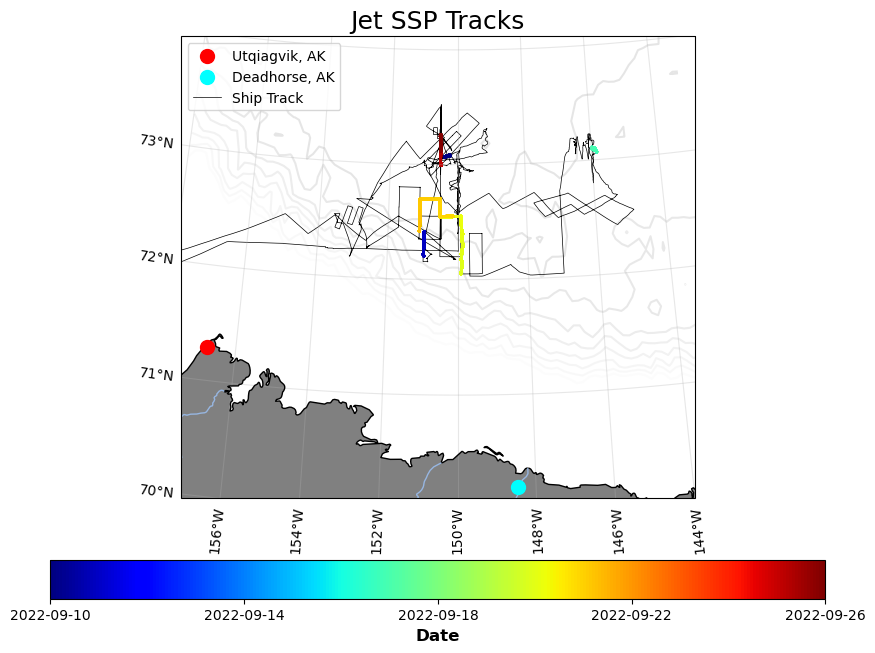

In [26]:
map_jetSSP_tracks()

In [6]:
def define_var_attributes(var):
    if (var=='wind_speed'): 
        colormap = 'cividis'
        var_label = 'Wind Speed (m/s)'
    if (var=='wind_direction'):
        colormap = 'twilight'
        var_label = 'Wind Direction ($^{\circ}$N)'
    if (var =='air_temperature'):
        colormap = 'magma'
        var_label = 'Air Temperature ($^{\circ}$C)'
    if (var == 'air_pressure'):
        colormap = 'Blues'
        var_label= 'Air Pressure (Pa)'
    if var =='salinity':
        colormap = 'viridis'
        var_label = 'Salinity'
    if var =='temperature':
        colormap = 'plasma'
        var_label = 'Water Temperature ($^{\circ}$C)'
    if var == 'time':
        colormap = 'jet'
        var_label = 'Date'
    if var=='pressure':
        colormap='Oranges'
        var_label = 'Pressure (dbar)'
    return colormap,var_label

In [14]:
## USE FOR SURFACE VARIABLES
def plot_jetssp_surface_data(deployment,var,var_min,var_max,ship_track=True,bathymetry_data=True,ice_data=False):
    
    colormap,var_label = define_var_attributes(var)
    
    #GET JET SSP DATA
    ds = xr.open_dataset(files[deployment-1])
    dates = pd.to_datetime(ds.time.values).date
    deployment_date = dates[0]
    
    if (var == 'temperature') | (var=='salinity') | (var=='pressure'):
        var_arr_1 = ds[var]
        if deployment ==1:
            var_arr = var_arr_1[1,:]
        else:
            var_arr = var_arr_1[0,:]
        lat = np.squeeze(ds['latitude'])
        lon = np.squeeze(ds['longitude'])
    else:
        var_arr = ds[var]
        lat = np.squeeze(ds['latitude'])
        lon = np.squeeze(ds['longitude'])
    
    ##CREATE A MAP WITH LAND AND CITY MARKERS 
    #To show the whole campaign area, use latmin = 70, latmax =74,lonmin=-157,lonmax=-140
    if (deployment == 1) | (deployment == 3):
        latmin = min(lat.values)-0.01
        latmax = max(lat.values)+0.01
        lonmin = min(lon.values)-0.1
        lonmax = max(lon.values)+0.1
    else:
        latmin = min(lat.values)-0.1
        latmax = max(lat.values)+0.1
        lonmin = min(lon.values)-0.1
        lonmax = max(lon.values)+0.1
     
    fig = plt.figure(figsize=(10,8))
    ax = plt.axes(projection=cartopy.crs.NorthPolarStereo(central_longitude=-150))
    ax.set_extent([lonmin,lonmax,latmin,latmax], crs=cartopy.crs.PlateCarree())
    ax.coastlines(color='k')  
    ax.add_feature(cartopy.feature.LAND, facecolor = '0.50')
    ax.add_feature(cartopy.feature.RIVERS,facecolor='blue')
    gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.3) #draw_labels=True gives lat labels. 
    ax.set_title('Jet SSP ' + str(deployment_date) +' '+ var_label +' Measurements',fontsize=15)
    xticks = list(np.linspace(lonmin,lonmax,4))
    yticks = list(np.linspace(latmin,latmax,4))
    gl.ylocator = matplotlib.ticker.FixedLocator(np.around(yticks,2))
    gl.xlocator = matplotlib.ticker.FixedLocator(np.around(xticks,2))
    gl.top_labels = False
    gl.bottom_labels = True 
    gl.right_labels = False
    
    if (latmin<71.2906) & (lonmin<-156.7886):
        utqiagvik = ax.scatter(-156.7886,71.2906,s=100,transform=cartopy.crs.PlateCarree(),c='red',marker = '*',label='Utqiagvik, AK')
    if (latmin<70.2002) & (lonmax>-148.4597):
        deadhorse = ax.scatter(-148.4597,70.2002,s=100,c='cyan',transform=cartopy.crs.PlateCarree(),marker = '*',label='Deadhorse, AK')
    
    
    ##OPTIONAL MAP ADD-ONs
    if ship_track==True:
        #ADD SHIP TRACK DATA
        ds_ship = xr.open_dataset(ship_dir)
        ship_time = np.squeeze(ds_ship['time'])
        ship_lat = np.squeeze(ds_ship['latitude'])
        ship_lon = np.squeeze(ds_ship['longitude'])
        track = ax.plot(ship_lon, 
                     ship_lat,linewidth = 0.5,
                     c='black',
                       transform=cartopy.crs.PlateCarree(),label = 'Ship Track',zorder=1)
        plt.legend(loc=2)
        
    if bathymetry_data == True:    
        ##ADD BATHYMETRY DATA
        topoin = etopodata.rose.values[0:-1:5,1:-1:5]
        lons = etopodata.etopo2_x.values[0:-1:5]
        lats = etopodata.etopo2_y.values[0:-1:5]
        lons_in_range = lons[np.where((lons >lonmin-1) & (lons<lonmax+1))]
        lats_in_range = lats[np.where((lats >latmin-1) & (lats<latmax+1))]
        topo_in_range = np.squeeze(topoin[np.squeeze(np.where((lats >latmin-1) & (lats<latmax+1))),:][:,np.where((lons >lonmin-1) & (lons<lonmax+1))])
        [bathy_lon,bathy_lat] = np.meshgrid(lons_in_range,lats_in_range)

        bathy = ax.contour(bathy_lon,bathy_lat,topo_in_range,np.arange(-6000,-1000,300),transform=cartopy.crs.PlateCarree(),cmap='gray',alpha = 0.2,zorder = 0)
        
    if ice_data==True:
        ##ADD ICE DATA. Will need to change lat min/max to see any ice data
        #get ice data from deplotment date
        start_time = min(dates)
        print(start_time)
        filename_si='AMSR_U2_L3_SeaIce12km_B04_'+str(start_time.year)+str(start_time.month).zfill(2)+str(start_time.day).zfill(2)+'.he5' 
        i=0
        time_tmp=start_time - timedelta(days=i)
        while os.path.isfile(ice_dir+filename_si)==False and i<15:
            time_tmp=start_time - timedelta(days=i)
            filename_si='AMSR_U2_L3_SeaIce12km_B04_'+str(time_tmp.year)+str(time_tmp.month).zfill(2)+str(time_tmp.day).zfill(2)+'.he5'
            url = requests.get('https://n5eil01u.ecs.nsidc.org/AMSA/AU_SI12.001/'+str(time_tmp.year)+'.'+str(time_tmp.month).zfill(2)+'.'+str(time_tmp.day).zfill(2)+'/'+filename_si)
            with open(ice_dir+filename_si, 'wb') as f:
                f.write(url.content)
            i=i+1

        
        #apply ice data from deployment date
        filename_si='AMSR_U2_L3_SeaIce12km_B04_'+str(start_time.year)+str(start_time.month).zfill(2)+str(start_time.day).zfill(2)+'.he5' 
        if os.path.isfile(ice_dir+filename_si):
            dsc = xr.open_dataset(ice_dir+filename_si,group='HDFEOS/GRIDS/NpPolarGrid12km')
            dsd = xr.open_dataset(ice_dir+filename_si,group='HDFEOS/GRIDS/NpPolarGrid12km/Data Fields') 
            var1 = np.array(dsd.SI_12km_NH_ICECON_DAY.squeeze().values)
            indx = np.where((var1==120) | (var1==0))
            var1[indx] = 0
            ice_location = np.ma.masked_where(var1==0,var1)

            pp = ax.pcolormesh(dsc.lon,dsc.lat,ice_location, 
                            vmin=0,vmax=100, # Set max and min values for plotting
                            cmap='Blues_r', shading='auto',   # shading='auto' to avoid warning
                            transform=cartopy.crs.PlateCarree())
    
    ##APPLY JET SSP DATA TO THE MAP
    jet_ssp_track = ax.scatter(lon, 
                 lat,s=0.01, 
                 c=var_arr,cmap=colormap,
                   transform=cartopy.crs.PlateCarree(),
                      vmin = var_min,
                      vmax = var_max,zorder = 2)
    
    jet_ssp_start = ax.scatter(lon[0], 
                lat[0],s=20, 
                c='cyan',
                 transform=cartopy.crs.PlateCarree(),zorder = 3)
    jet_ssp_end = ax.scatter(lon[lon.size-1], 
                lat[lat.size-1],s=80, 
                c='cyan',marker = '*',
                 transform=cartopy.crs.PlateCarree(),zorder = 3)
                        
    matplotlib.pyplot.colorbar(jet_ssp_track, ax=ax, orientation="horizontal", pad=0.2).set_label(label=var_label,size='large',weight='bold')
    
    
    ##SAVE FIGURE
    if not os.path.exists(fig_dir+'/'+var+'/maps'):
        os.makedirs(fig_dir+'/'+var+'/maps')
        
    print('Saving Output Image:  '+fig_dir+'/'+var+'/maps/SASSIE_jetSSP_Deployment'+str(deployment)+'_'+var+'_surface.png')
    plt.savefig(fig_dir+'/'+var+'/maps/SASSIE_jet_SSP_Deployment'+str(deployment)+'_'+var+'_surface.png',dpi='figure',format='png')
    
    

Saving Output Image:  /Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/communication/notebooks_images/jet_SSP//temperature/maps/SASSIE_jetSSP_Deployment1_temperature_surface.png


/Users/westbrooke/opt/anaconda3/envs/SASSIE_Data/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


Saving Output Image:  /Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/communication/notebooks_images/jet_SSP//temperature/maps/SASSIE_jetSSP_Deployment2_temperature_surface.png


/Users/westbrooke/opt/anaconda3/envs/SASSIE_Data/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


Saving Output Image:  /Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/communication/notebooks_images/jet_SSP//temperature/maps/SASSIE_jetSSP_Deployment3_temperature_surface.png


/Users/westbrooke/opt/anaconda3/envs/SASSIE_Data/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


Saving Output Image:  /Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/communication/notebooks_images/jet_SSP//temperature/maps/SASSIE_jetSSP_Deployment4_temperature_surface.png


/Users/westbrooke/opt/anaconda3/envs/SASSIE_Data/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


Saving Output Image:  /Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/communication/notebooks_images/jet_SSP//temperature/maps/SASSIE_jetSSP_Deployment5_temperature_surface.png


/Users/westbrooke/opt/anaconda3/envs/SASSIE_Data/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


Saving Output Image:  /Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/communication/notebooks_images/jet_SSP//temperature/maps/SASSIE_jetSSP_Deployment6_temperature_surface.png


/Users/westbrooke/opt/anaconda3/envs/SASSIE_Data/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


Saving Output Image:  /Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/communication/notebooks_images/jet_SSP//temperature/maps/SASSIE_jetSSP_Deployment7_temperature_surface.png


/Users/westbrooke/opt/anaconda3/envs/SASSIE_Data/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


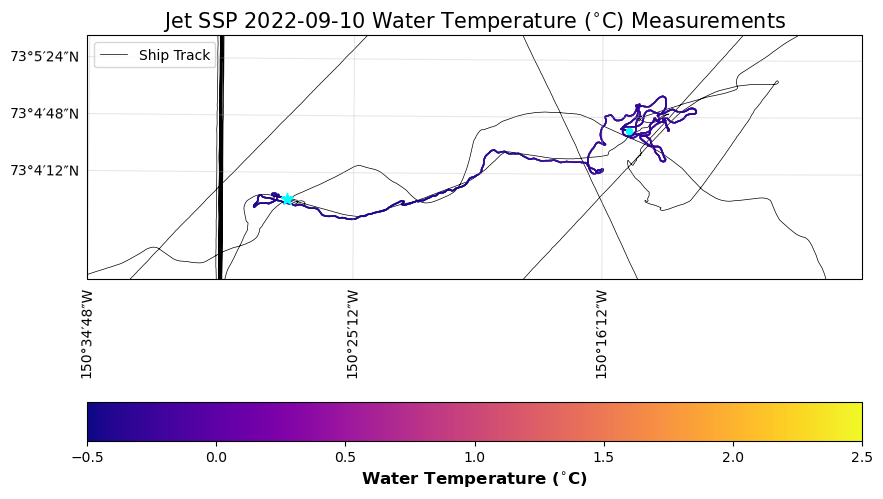

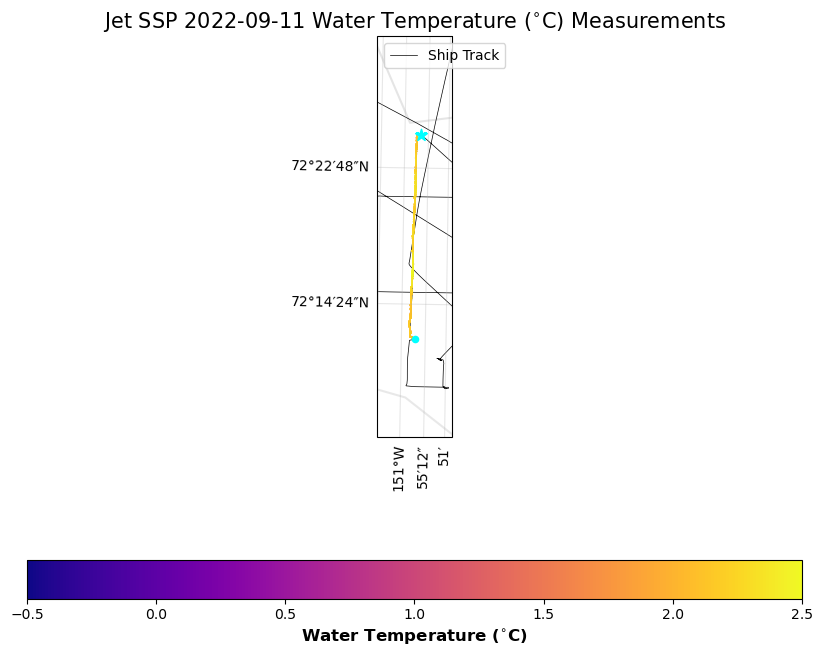

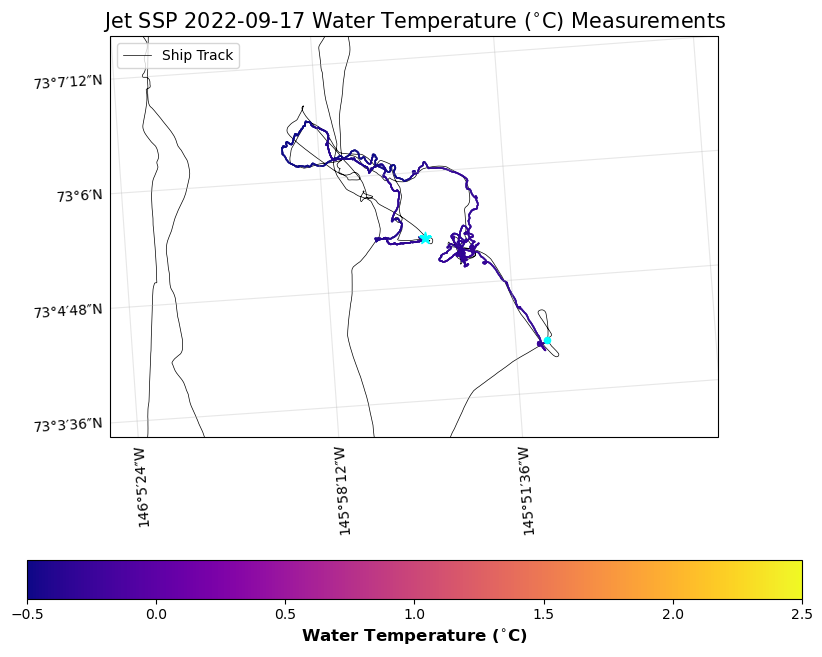

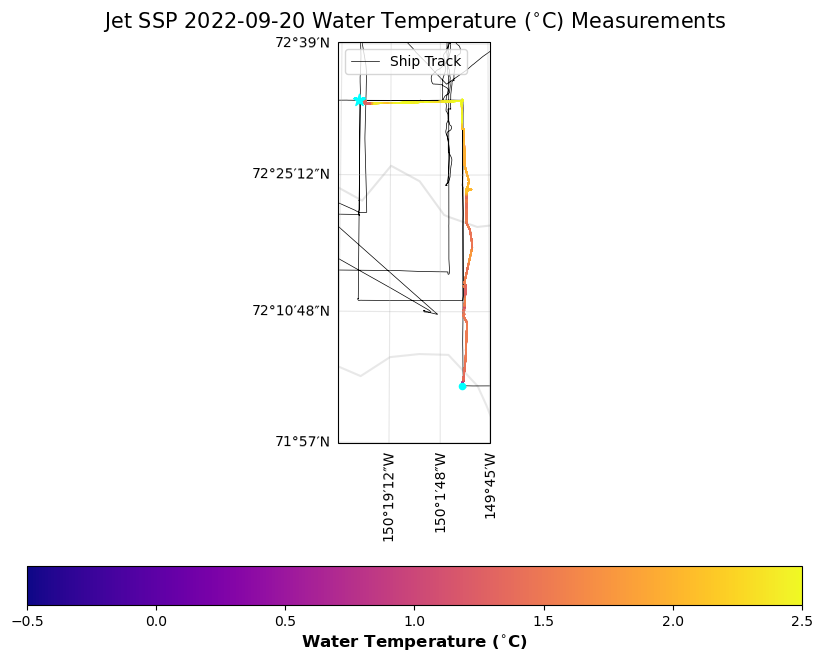

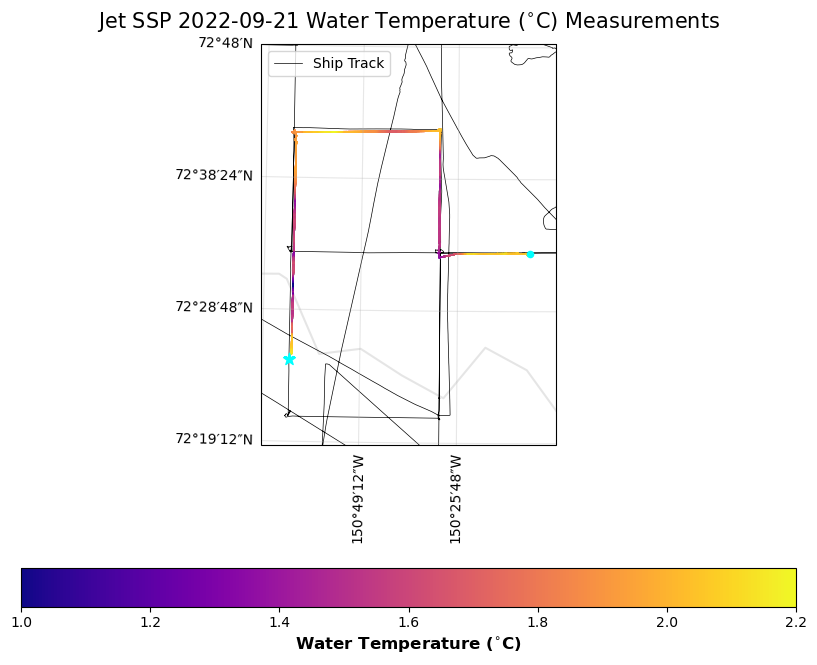

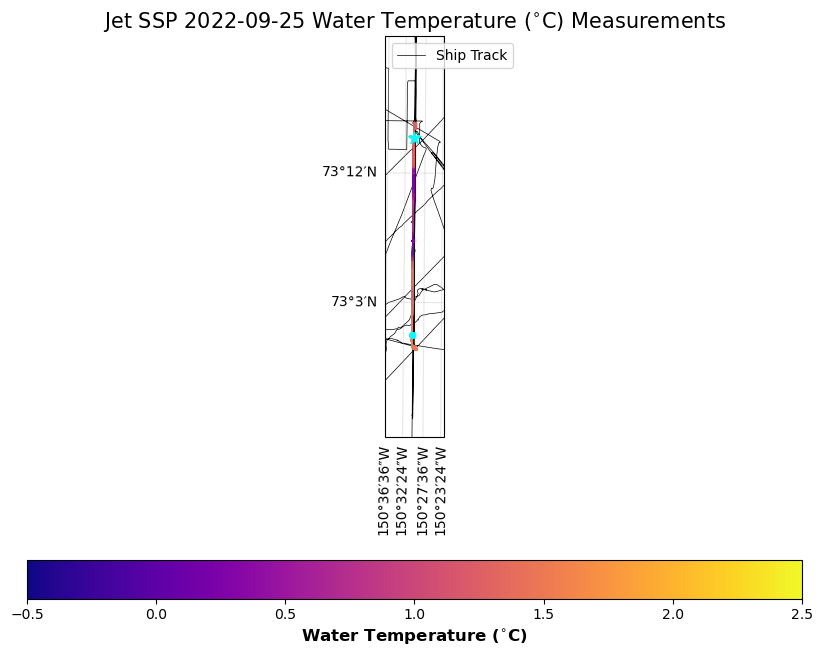

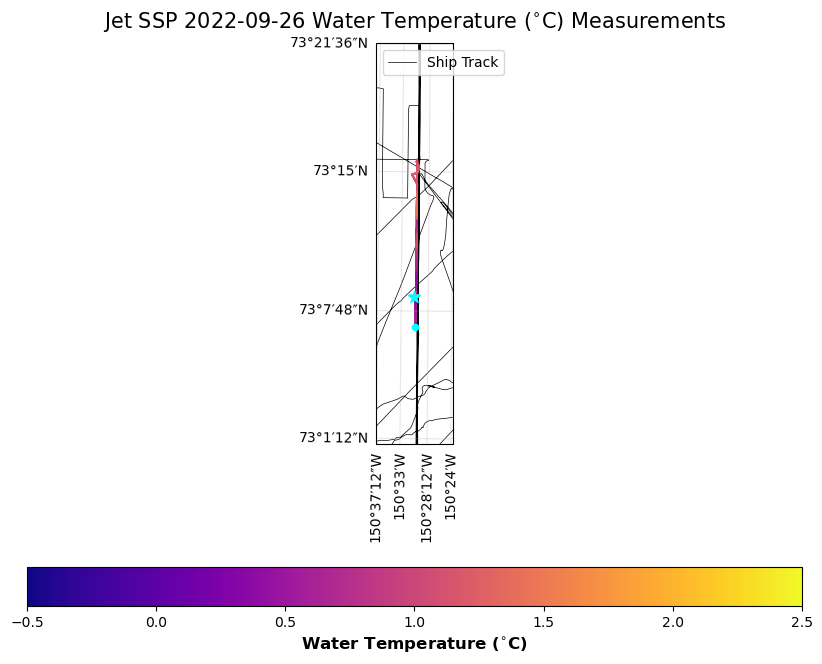

In [15]:
plot_jetssp_surface_data(1,'temperature',-0.5,2.5)
plot_jetssp_surface_data(2,'temperature',-0.5,2.5)
plot_jetssp_surface_data(3,'temperature',-0.5,2.5)
plot_jetssp_surface_data(4,'temperature',-0.5,2.5)
plot_jetssp_surface_data(5,'temperature',1,2.2)
plot_jetssp_surface_data(6,'temperature',-0.5,2.5)
plot_jetssp_surface_data(7,'temperature',-0.5,2.5)

Saving Output Image:  /Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/communication/notebooks_images/jet_SSP//salinity/maps/SASSIE_jetSSP_Deployment1_salinity_surface.png


/Users/westbrooke/opt/anaconda3/envs/SASSIE_Data/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


Saving Output Image:  /Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/communication/notebooks_images/jet_SSP//salinity/maps/SASSIE_jetSSP_Deployment2_salinity_surface.png


/Users/westbrooke/opt/anaconda3/envs/SASSIE_Data/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


Saving Output Image:  /Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/communication/notebooks_images/jet_SSP//salinity/maps/SASSIE_jetSSP_Deployment3_salinity_surface.png


/Users/westbrooke/opt/anaconda3/envs/SASSIE_Data/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


Saving Output Image:  /Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/communication/notebooks_images/jet_SSP//salinity/maps/SASSIE_jetSSP_Deployment4_salinity_surface.png


/Users/westbrooke/opt/anaconda3/envs/SASSIE_Data/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


Saving Output Image:  /Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/communication/notebooks_images/jet_SSP//salinity/maps/SASSIE_jetSSP_Deployment5_salinity_surface.png


/Users/westbrooke/opt/anaconda3/envs/SASSIE_Data/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


Saving Output Image:  /Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/communication/notebooks_images/jet_SSP//salinity/maps/SASSIE_jetSSP_Deployment6_salinity_surface.png


/Users/westbrooke/opt/anaconda3/envs/SASSIE_Data/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


Saving Output Image:  /Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/communication/notebooks_images/jet_SSP//salinity/maps/SASSIE_jetSSP_Deployment7_salinity_surface.png


/Users/westbrooke/opt/anaconda3/envs/SASSIE_Data/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


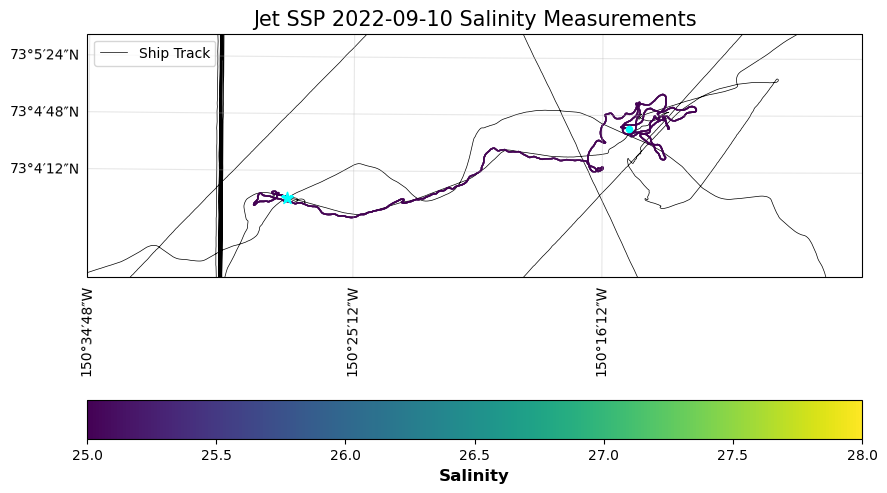

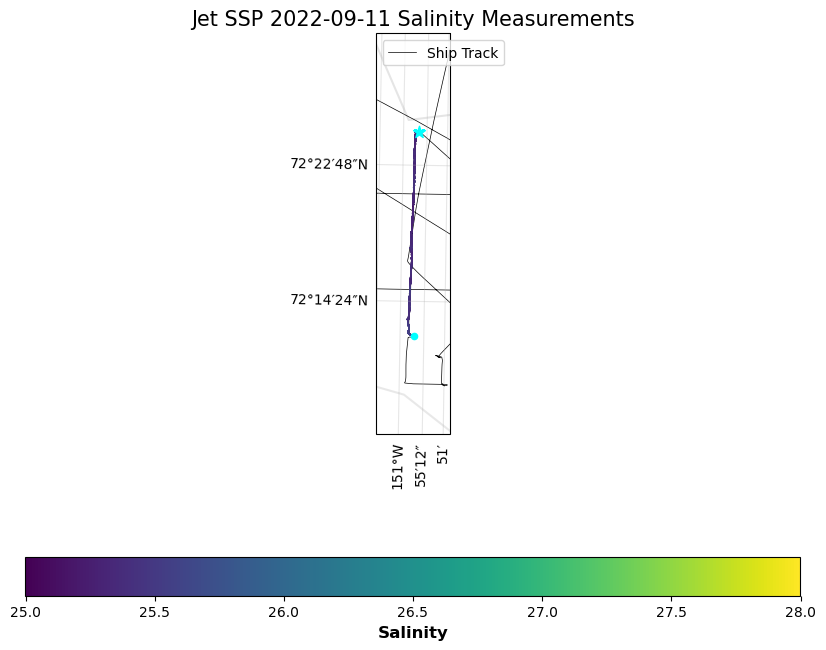

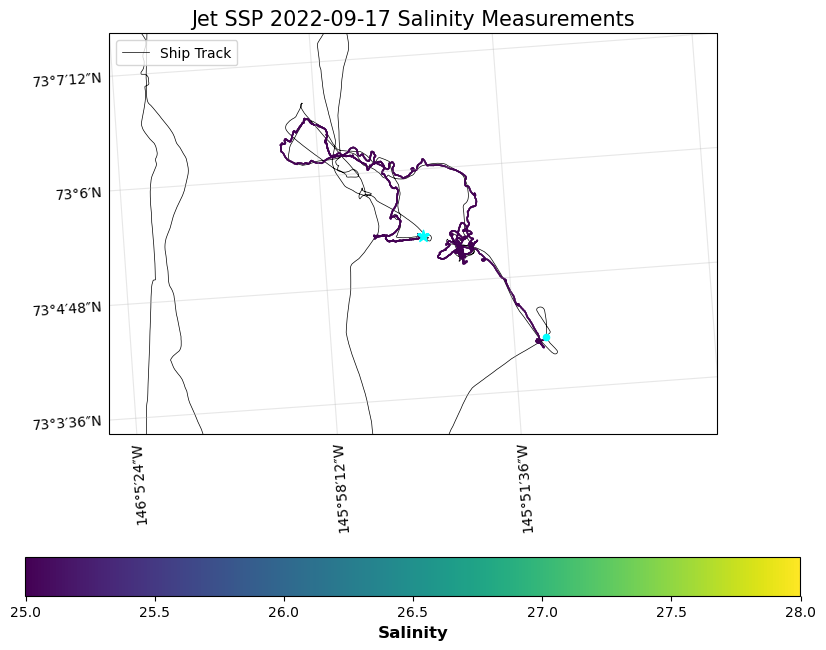

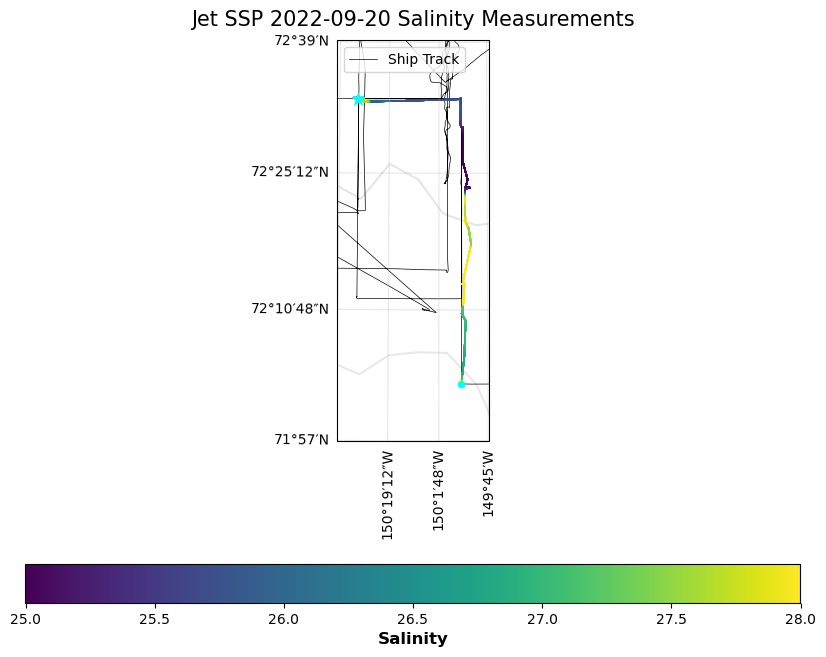

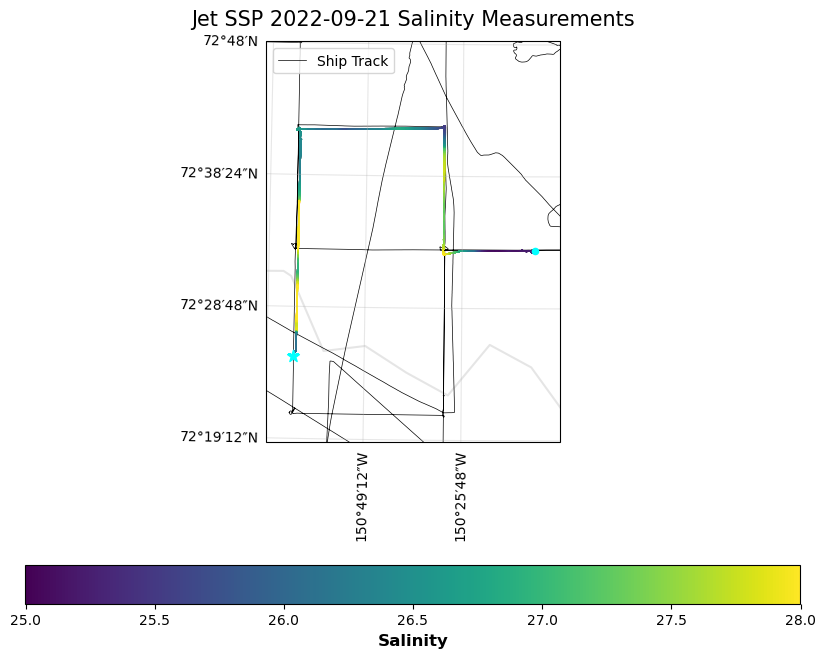

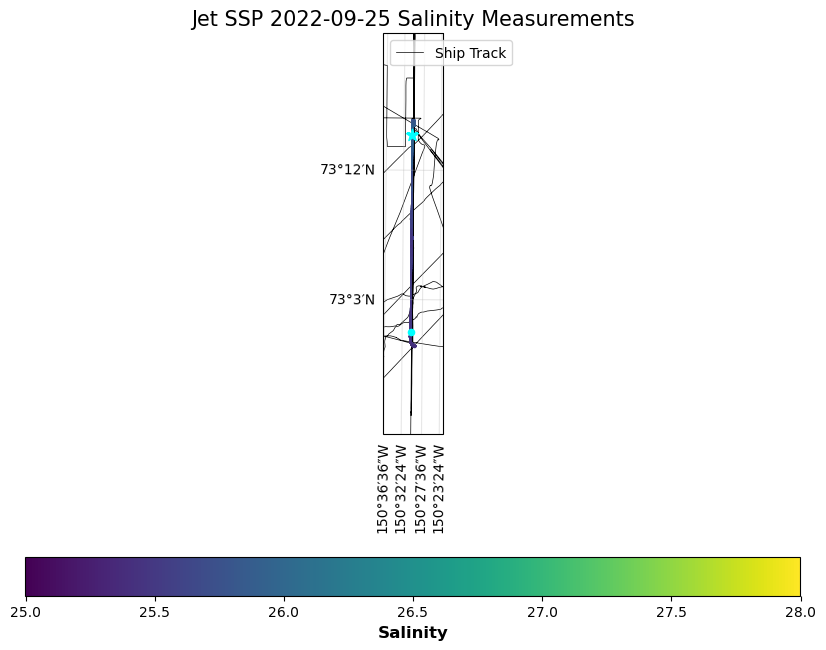

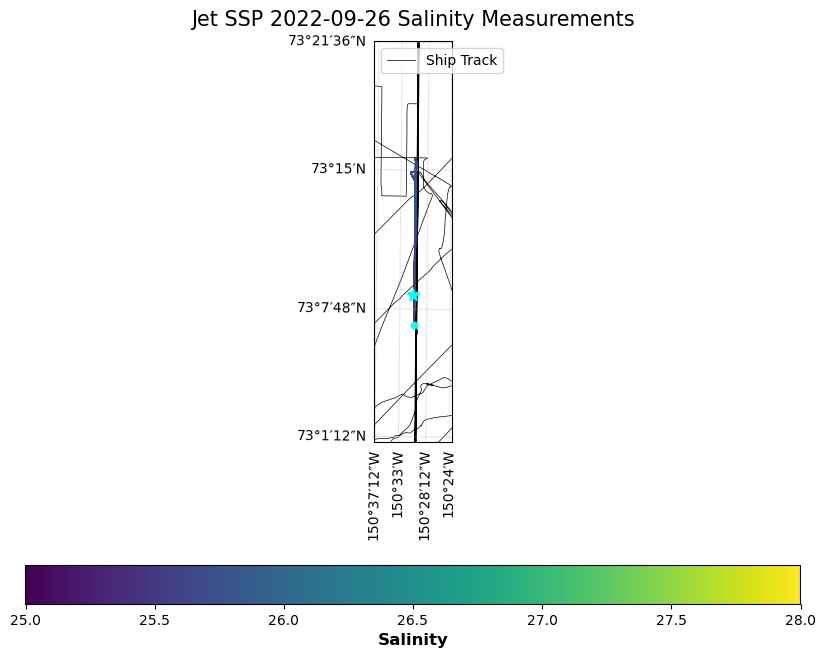

In [16]:
plot_jetssp_surface_data(1,'salinity',25,28)
plot_jetssp_surface_data(2,'salinity',25,28)
plot_jetssp_surface_data(3,'salinity',25,28)
plot_jetssp_surface_data(4,'salinity',25,28)
plot_jetssp_surface_data(5,'salinity',25,28)
plot_jetssp_surface_data(6,'salinity',25,28)
plot_jetssp_surface_data(7,'salinity',25,28)

Saving Output Image:  /Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/communication/notebooks_images/jet_SSP//wind_speed/maps/SASSIE_jetSSP_Deployment4_wind_speed_surface.png


/Users/westbrooke/opt/anaconda3/envs/SASSIE_Data/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


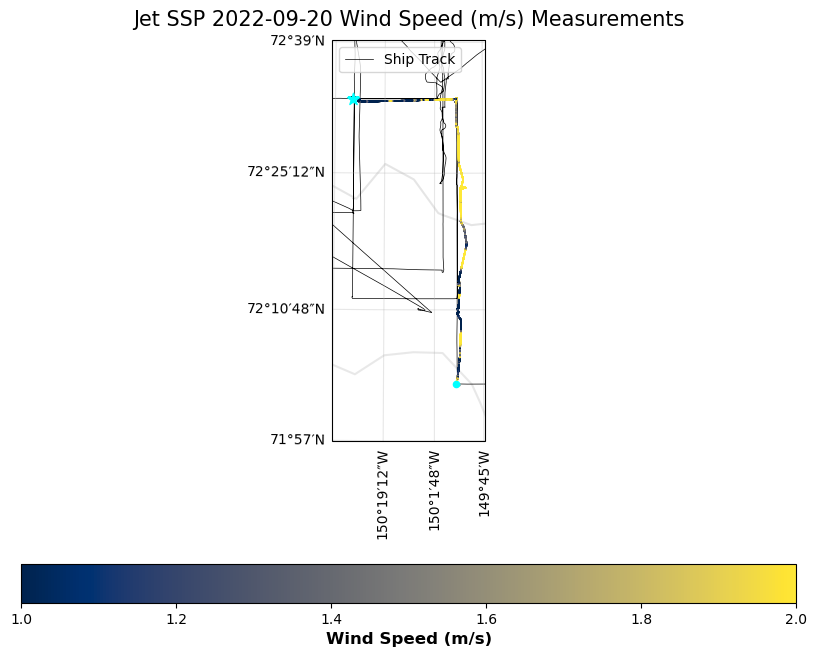

In [17]:
plot_jetssp_surface_data(4,'wind_speed',1,2)

In [18]:
## USE FOR DATA VARIABLES WITH A DEPTH DIMENSION 
def plot_jetssp_data(deployment,var):
    
    colormap,var_label = define_var_attributes(var)

    #GET JET SSP DATA
    ds = xr.open_dataset(files[deployment-1])
    dates = pd.to_datetime(ds.time.values).date
    deployment_date = dates[0]
    var_arr = ds[var]
    lat = np.squeeze(ds['latitude'])
    lon = np.squeeze(ds['longitude'])
    depth = np.squeeze(ds['depth'])
    
    ##CREATE 3D PLOT 
    latmin = min(lat.values)
    latmax = max(lat.values)
    lonmin = min(lon.values)
    lonmax = max(lon.values)
    dmin = min(depth.values)
    dmax = max(depth.values)+0.5
    
    fig = plt.figure(figsize=(10,8))
    ax = plt.axes(projection='3d',computed_zorder=False)
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False

    ax.set_xlim(lonmin, lonmax); ax.set_ylim(latmin,latmax); ax.set_zlim(dmin,dmax);
    ax.get_xaxis().get_major_formatter().set_useOffset(False)
    xticks = list(np.linspace(lonmin,lonmax,4))
    ax.set_xticks(np.around(xticks,2))
    yticks = list(np.linspace(latmin,latmax,4))
    ax.set_yticks(np.around(yticks,2))
    ax.set_zticks(depth.values)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_zlabel('Depth (m)')
    ax.view_init(195, 70)
    if deployment == 2:
        ax.view_init(195, 80)

    ax.set_title('JetSSP'+ ' '+str(deployment_date)+' '+var_label,fontsize=15)
    
    #APPLY JET SSP DATA
    z_1 = np.full((1,lat.size), depth.values[0])
    z_2 = np.full((1,lat.size), depth.values[1])
    z_3 = np.full((1,lat.size), depth.values[2])
    z_4 = np.full((1,lat.size), depth.values[3])
    
    z = np.concatenate((z_1,z_2,z_3,z_4),axis=1)
    all_lon = np.concatenate((lon.values,lon.values,lon.values,lon.values), axis=0)
    all_lat = np.concatenate((lat.values,lat.values,lat.values,lat.values), axis=0)
     
    a = ax.scatter(all_lon,all_lat,z,c=(var_arr.values),cmap = colormap,s=0.5,zorder=1)
    
    fig.colorbar(a,label = var_label)
    
    if deployment == 1:
        surface = 0.29
    else:
        surface = 0.05
        
    b = ax.scatter(all_lon[0],all_lat[0],surface,c='cyan',s=40,zorder=2)
    c = ax.scatter(all_lon[all_lon.size-1],all_lat[all_lat.size-1],surface,c='cyan',s=80,zorder=2,marker='*')
    

    ##SAVE FIGURE  
    if not os.path.exists(fig_dir+'/'+var+'/profiles'):
        os.makedirs(fig_dir+'/'+var+'/profiles')
        
        
    print('Saving Output Image:  '+fig_dir+'/'+var+'/profiles/SASSIE_jetSSP_Deployment'+str(deployment)+'_'+var+'.png')
    plt.savefig(fig_dir+'/'+var+'/profiles/SASSIE_jet_SSP_Deployment'+str(deployment)+'_'+var+'.png',dpi='figure',format='png')
    



Saving Output Image:  /Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/communication/notebooks_images/jet_SSP//temperature/profiles/SASSIE_jetSSP_Deployment1_temperature.png
Saving Output Image:  /Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/communication/notebooks_images/jet_SSP//temperature/profiles/SASSIE_jetSSP_Deployment2_temperature.png
Saving Output Image:  /Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/communication/notebooks_images/jet_SSP//temperature/profiles/SASSIE_jetSSP_Deployment3_temperature.png
Saving Output Image:  /Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/communication/notebooks_images/jet_SSP//temperature/profiles/SASSIE_jetSSP_Deployment4_temperature.png
Saving Output Image:  /Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/communication/notebooks_images/jet_SSP//temperature/profiles/SASSIE_jetSSP_Deployment5_temperature.png
Saving Output Image:  /Us

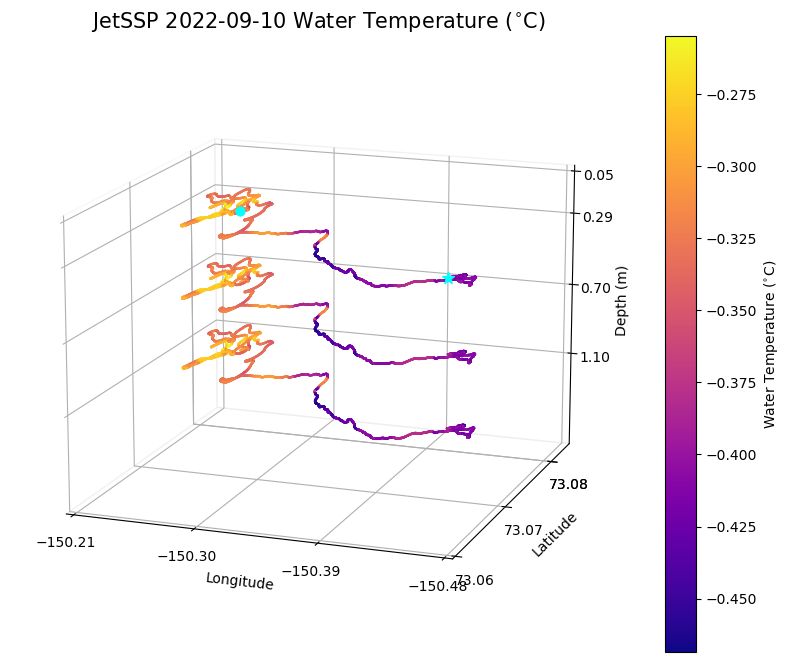

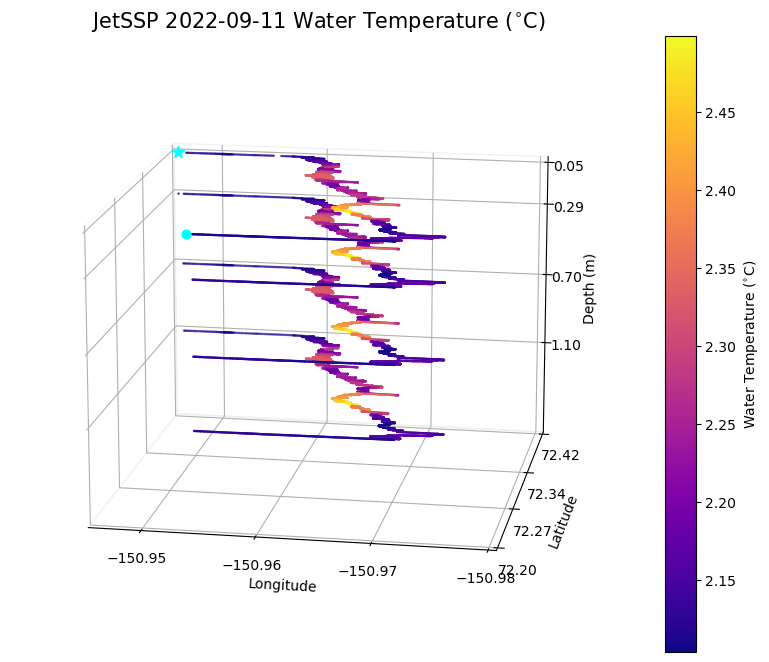

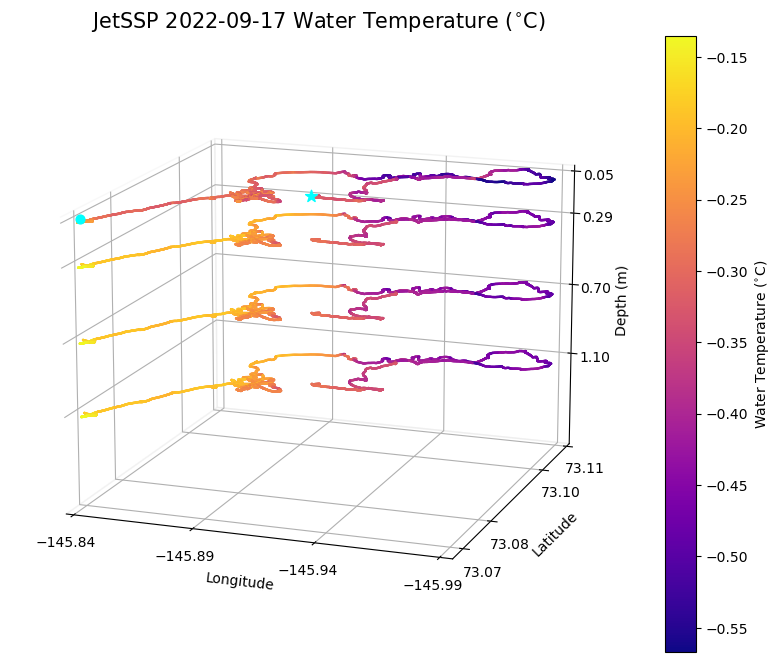

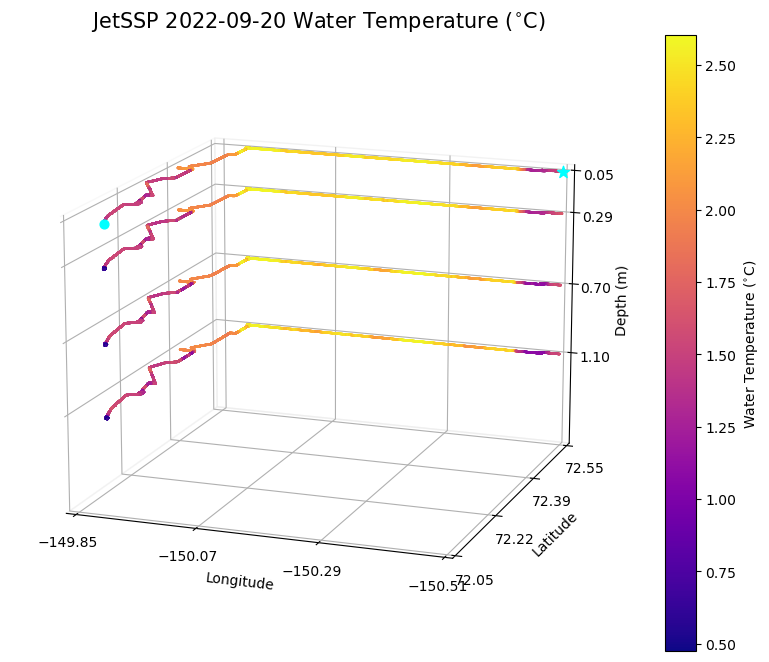

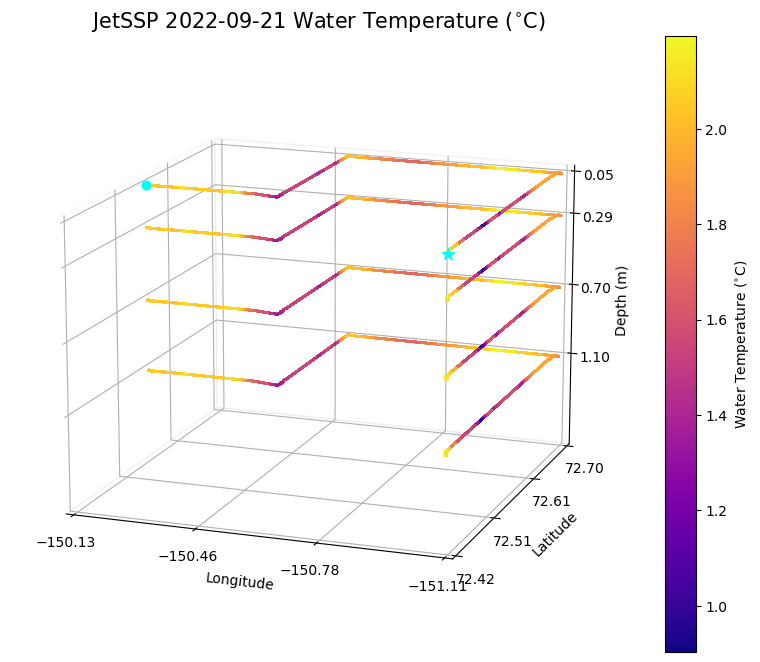

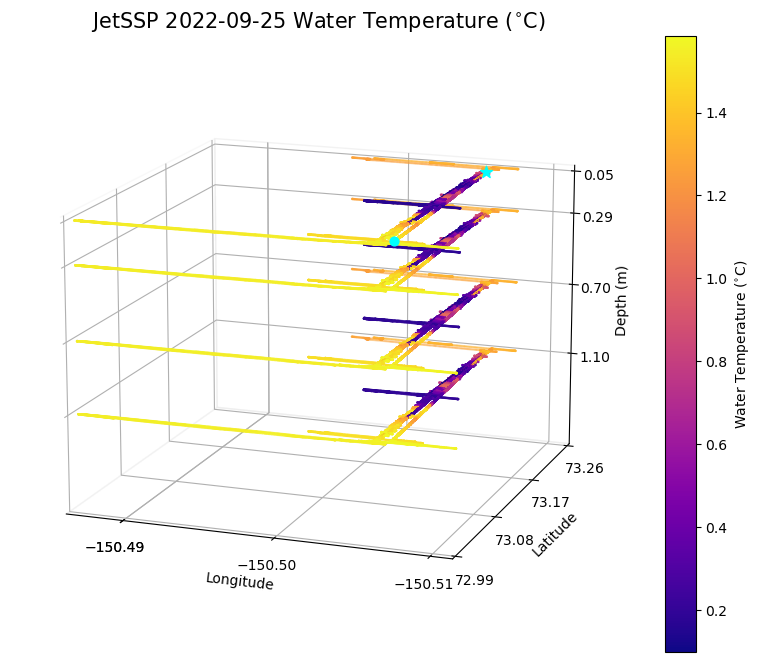

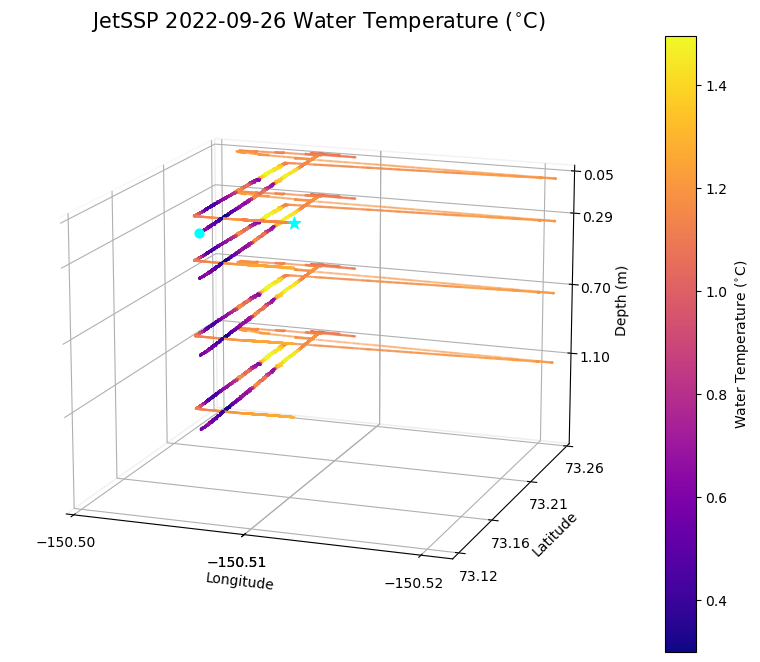

In [19]:
plot_jetssp_data(1,'temperature')
plot_jetssp_data(2,'temperature')
plot_jetssp_data(3,'temperature')
plot_jetssp_data(4,'temperature')
plot_jetssp_data(5,'temperature')
plot_jetssp_data(6,'temperature')
plot_jetssp_data(7,'temperature')


Saving Output Image:  /Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/communication/notebooks_images/jet_SSP//salinity/profiles/SASSIE_jetSSP_Deployment1_salinity.png
Saving Output Image:  /Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/communication/notebooks_images/jet_SSP//salinity/profiles/SASSIE_jetSSP_Deployment2_salinity.png
Saving Output Image:  /Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/communication/notebooks_images/jet_SSP//salinity/profiles/SASSIE_jetSSP_Deployment3_salinity.png
Saving Output Image:  /Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/communication/notebooks_images/jet_SSP//salinity/profiles/SASSIE_jetSSP_Deployment4_salinity.png
Saving Output Image:  /Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/communication/notebooks_images/jet_SSP//salinity/profiles/SASSIE_jetSSP_Deployment5_salinity.png
Saving Output Image:  /Users/westbrooke/Library/CloudSt

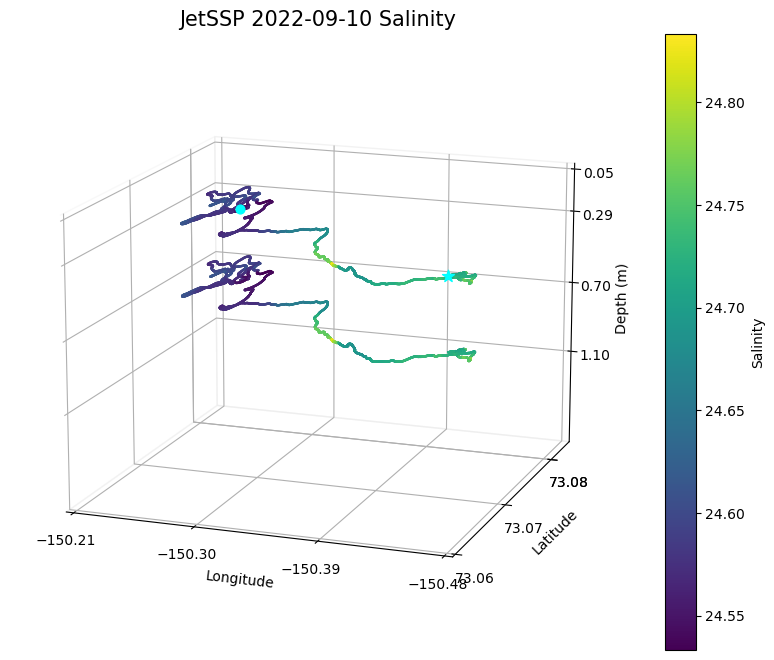

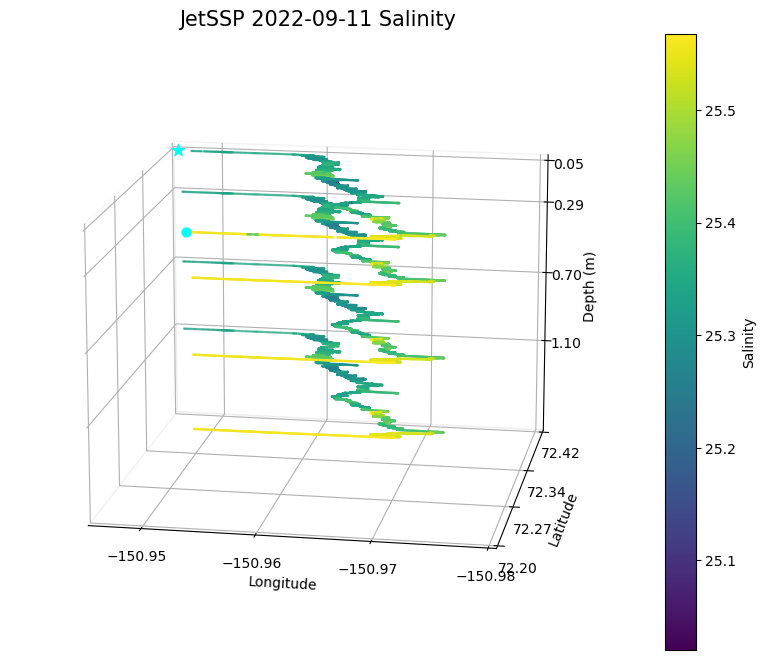

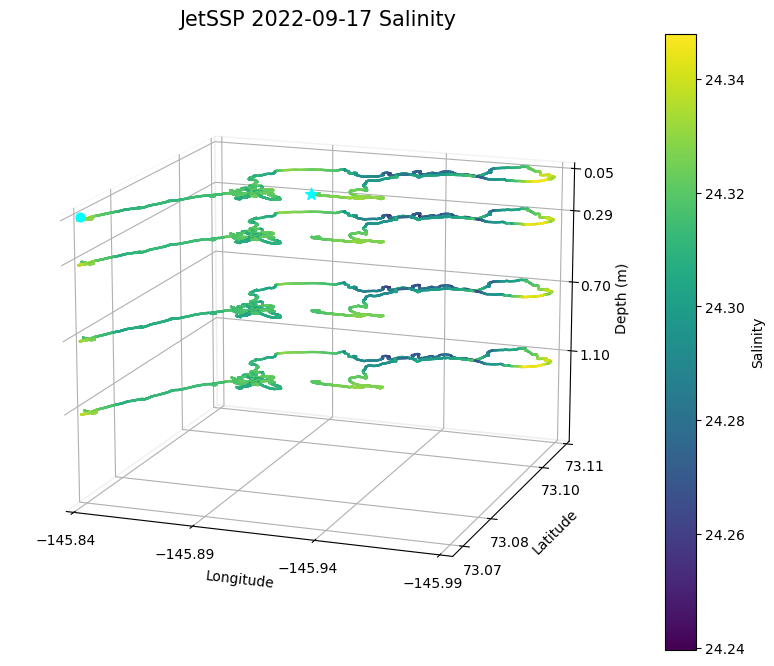

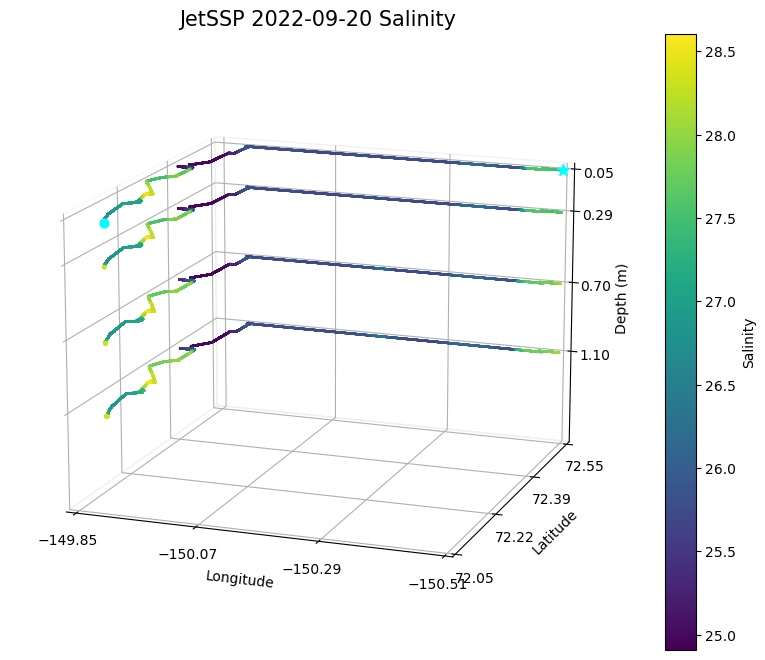

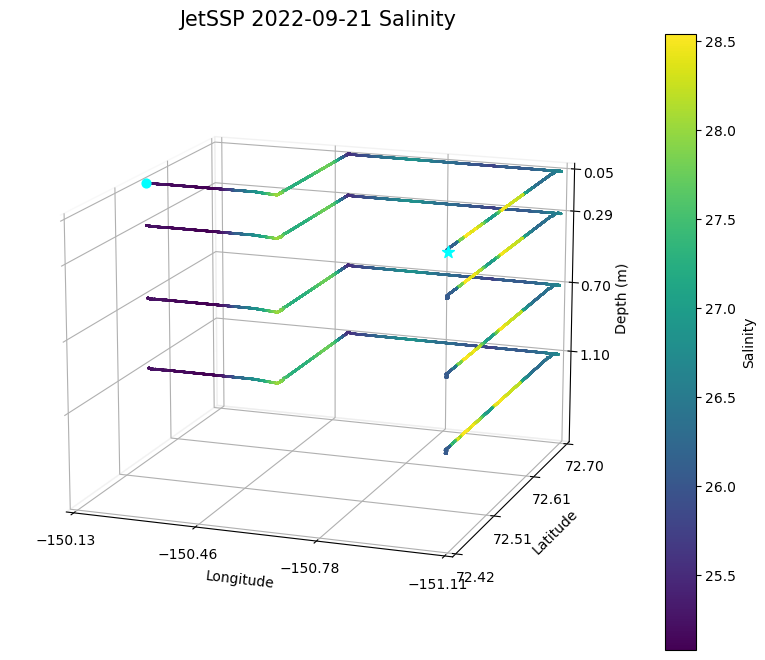

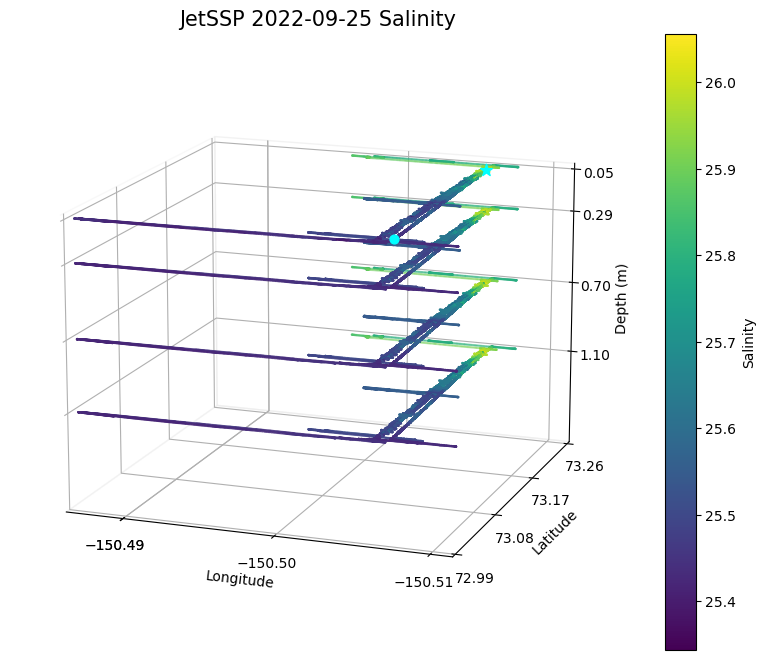

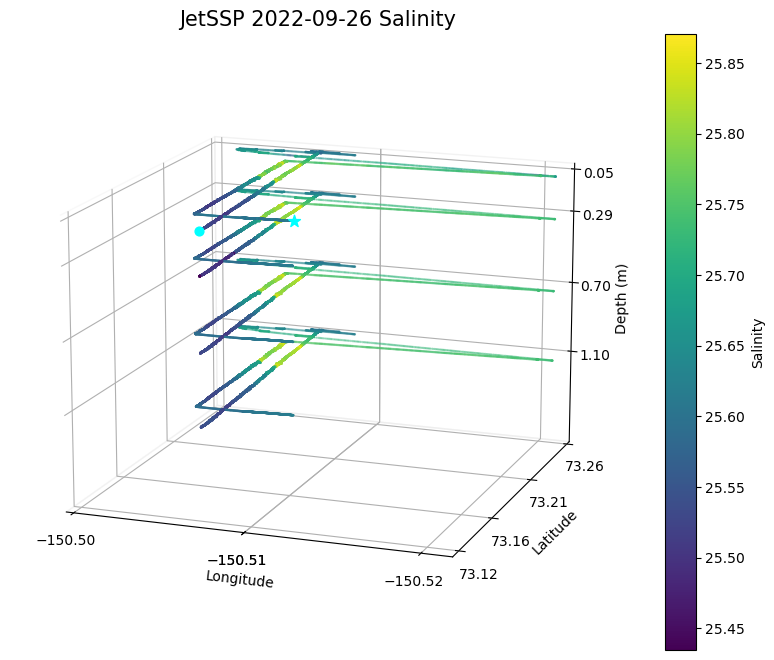

In [20]:
plot_jetssp_data(1,'salinity')
plot_jetssp_data(2,'salinity')
plot_jetssp_data(3,'salinity')
plot_jetssp_data(4,'salinity')
plot_jetssp_data(5,'salinity')
plot_jetssp_data(6,'salinity')
plot_jetssp_data(7,'salinity')



In [21]:
def plot_jetSSP_timeseries(deployment,var1,var2,var3): 
    
    #SECLECT AND LOAD JET SSP DATA
    ds = xr.open_dataset(files[deployment-1])
    deployment_date = pd.to_datetime(ds.time.values).date[0]
    time_data = ds['time']
    [colormap,var1_label] = define_var_attributes(var1)
    [colormap,var2_label] = define_var_attributes(var2)
    [colormap,var3_label] = define_var_attributes(var3)
    var1_data = ds[var1]
    var2_data = ds[var2]
    var3_data = ds[var3]
        
    #MAKE A THREE PANELED TIME SERIES PLOT
    fig,axs = plt.subplots(3,sharex=True)
    
    if var1_data.ndim < 2:
        axs[0].plot(time_data,var1_data,linewidth=0.4,c='black')
    else:
        axs[0].plot(time_data,var1_data[0,:],linewidth=0.4,label = '0.05m')
        axs[0].plot(time_data,var1_data[1,:],linewidth=0.4,label = '0.29m')
        axs[0].plot(time_data,var1_data[2,:],linewidth=0.4,label = '0.7m')
        axs[0].plot(time_data,var1_data[3,:],linewidth=0.4,label = '1.1m')
    axs[0].set(ylabel=var1_label)
    
    if var2_data.ndim<2:
        axs[1].plot(time_data,var2_data,linewidth=0.4,c='black')
    else: 
        axs[1].plot(time_data,var2_data[0,:],linewidth=0.4,label = '0.05m')
        axs[1].plot(time_data,var2_data[1,:],linewidth=0.4,label = '0.29m')
        axs[1].plot(time_data,var2_data[2,:],linewidth=0.4,label = '0.7m')
        axs[1].plot(time_data,var2_data[3,:],linewidth=0.4,label = '1.1m')
    axs[1].set(ylabel=var2_label)
    
    if var3_data.ndim<2:
        axs[2].plot(time_data,var3_data,linewidth=0.4,c='black')
    else: 
        axs[2].plot(time_data,var3_data[0,:],linewidth=0.4)
        axs[2].plot(time_data,var3_data[1,:],linewidth=0.4)
        axs[2].plot(time_data,var3_data[2,:],linewidth=0.4)
        axs[2].plot(time_data,var3_data[3,:],linewidth=0.4)
    axs[2].set(ylabel=var3_label,xlabel = 'Date')
    plt.xticks(pd.date_range(start=time_data.values[0],end=time_data.values[-1],periods=3))
    fig.suptitle(var1_label+', '+var2_label+', and '+var3_label+' Data from JetSSP '+str(deployment_date),fontsize=10)
    
    #Ideal location for legend may vary depending on which data is plotted 
    if any([var1_data.ndim>1,var2_data.ndim>1,var3_data.ndim>1]):
        #axs[1].legend(loc=1,bbox_to_anchor=(1.25,1.0))
        axs[0].legend(loc=3,ncol=4,fontsize=9)

    
        
    ##SAVE FIGURE 
    if not os.path.exists(fig_dir+'/timeseries'):
        os.makedirs(fig_dir+'/timeseries')
    print('Saving Output Image:  '+fig_dir+'/timeseries/JetSSP_Deployment_'+str(deployment)+'_'+var1+'_'+var2+'_'+var3+'.png')
    plt.savefig(fig_dir+'/timeseries/JetSSP_Deployment_'+str(deployment)+'_'+var1+'_'+var2+'_'+var3+'.png',dpi='figure',format='png')
    

Saving Output Image:  /Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/communication/notebooks_images/jet_SSP//timeseries/JetSSP_Deployment_4_temperature_salinity_wind_speed.png


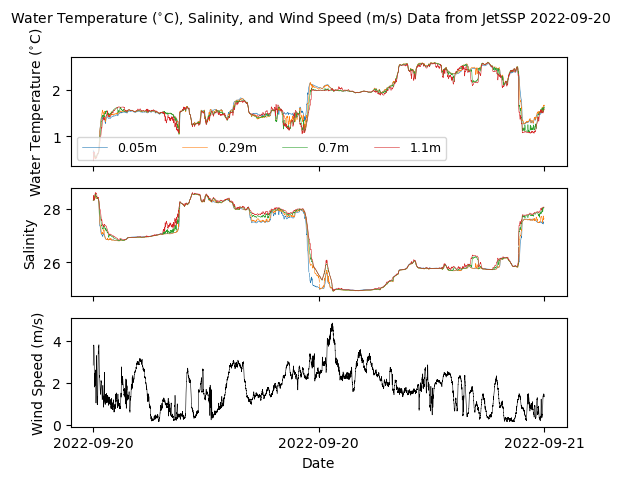

In [27]:
plot_jetSSP_timeseries(4,'temperature','salinity','wind_speed')